In [1]:
########################################################################拿取資料
def get_feature(subject='公用事業'):
    '''取得price data & 製作features'''
    import pandas as pd
    import numpy as np
    import tqdm
    import matplotlib.pyplot as plt
    %matplotlib inline
    plt.style.use("ggplot")
    
    #參數設定
    #observe_period = 60
    #predict_period = 60
    #predict_cycle=1
    
    
    df=pd.read_excel('ETF_price.xlsx', sheet_name ='price',encoding='big5')
    df['Date']=pd.to_datetime(df['Date'])
    df=df.set_index(keys=['Date'])
    df.sort_values("Date",inplace=True)    
    #轉成set
    column_name=set(df.columns)  
    #保留資料長度>2400的
    #for name in column_name:
    #    if df[name].count()<2400:
    #        df=df.drop(columns=[name])
    
    
    
    
    #製作(產業&國家~~ISIN) dictionary
    industry_dic={'美國':'SPX Index',
                  '泛太平洋':'MXAP Index',
                  '拉丁美洲':'MXLA Index',
                  '新興亞洲':'MXMS Index',
                  '新興歐洲':'MXMU Index',
                  '歐洲':'SX5P Index',
                  '非核心消費':'MXWO0CD Index',
                  '地產':'MXWO0RE Index',
                  '公用事業':'MXWO0UT Index',
                  '核心消費':'MXWO0CS Index',
                  '科技':'MXWO0IT Index',
                  '工業':'MXWO0IN Index',
                  '健護':'MXWO0HC Index',
                  '原物料':'MXWO0MT Index',
                  '能源':'MXWO0EN Index',
                  '金融':'MXWO0FN Index',
                  '電信':'MXWO0TC Index',

                 }                
    #industry_list=['非核心消費',
    #              '地產',
    #              '公用事業',
    #              '核心消費',
    #              '美國']   
              
    price=df[industry_dic[subject]].dropna()
    
    
    #補上 predict_period 個假資料 (for 預測
    #dti=pd.date_range(price.index[-1]+pd.Timedelta(days=1),freq='D',periods=predict_period)
    #temp=pd.Series(index=dti)
    #price=pd.concat([price,temp])
    
    
    
    
    
    indexes = price.index    
    #Split traning and testing data
    import datetime
    price_train = price[indexes < datetime.datetime(2012,1,1)]
    price_test = price[indexes >= datetime.datetime(2012,1,1)]    
    
    
    return (price_train,price_test,price,indexes)

In [10]:
########################################################################回測 function  (反均線策略)

def backtest_antiMA(price,indexes,plot=False,p_rolling=60,p_enter=12,p_esc=29):
    '''用來回測的function'''
    import math
    import mymath
    import imp
    imp.reload(mymath)
    import talib
    import pandas as pd
    import numpy as np
    #參數設定~~~~停損&停利&稅(%)
    stop_gain_ratio=0.2
    stop_loss_ratio=0.05
    tax_rate=0.01
    #時間停損參數?????



    eq = price[pd.to_datetime(indexes)]
    returns= (eq.shift(-1)/eq).dropna()
    returns_b= (eq.shift(-1)/eq).dropna()
    


    ######################################################################### 
    #匯入策略
    (buy,signal_sell)=strategy_antiMA(p_rolling=p_rolling,p_enter=p_enter,p_esc=p_esc,eq=eq) 
    atr = talib.NATR(eq,eq,eq,timeperiod=p_rolling)
      
    ##########################################################################         
    hold = pd.Series(np.nan, index=eq.index)
    ko = pd.Series(np.nan, index=eq.index)    
    hold[buy] = 1
    ko[signal_sell] = 1    
    
    
    sell = pd.Series(np.nan, index=eq.index)
    stop_gain=pd.Series(np.nan, index=eq.index)
    stop_loss=pd.Series(np.nan, index=eq.index)
    

    #出訊後15天內不得再出訊
    #for n in range(0,len(hold),1):
    #    if hold[n]==1:
    #        for i in range(1,15,1):
    #            if i<len(hold)-n:
    #                hold[n+i]=np.nan
            

            
    gain_list=[]
    win=0
    turnover=0
          
    #創建損益紀錄表格    
    df_tradingrecord=pd.DataFrame(columns=['date','buy/sell','price','stop_gain_price','stop_loss_price','profit'])
    k=0
          
    for n in range(0,len(hold),1):
    
        if (hold[n]==1)  & (hold[n-1]!=1):
            price0=eq[n]
            stop_gain_price=eq[n]*(1+stop_gain_ratio)
            stop_loss_price=eq[n]*(1-stop_loss_ratio)
            stop_gain[n]=stop_gain_price
            stop_loss[n]=stop_loss_price   
            
            
            #紀錄進場
            df_tradingrecord.loc[k,['date']]=eq.index[n]
            df_tradingrecord.loc[k,['buy/sell']]='buy'
            df_tradingrecord.loc[k,['price']]=price0
            df_tradingrecord.loc[k,['stop_gain_price']]=stop_gain_price
            df_tradingrecord.loc[k,['stop_loss_price']]=stop_loss_price            
            k=k+1
            
                  
            
            #判斷出場
            high=eq[n]
            #stop_loss_ratio=atr[n]/100*2   #動態停損參數
            for i in range(n+1,len(hold),1):
                hold[i]=1
                stop_gain[i]=stop_gain_price
                stop_loss[i]=stop_loss_price
                
                
                if eq[i]>high:
                    high=eq[i]
                
                
                #每60天重新review一次__若signal消失就出場   (時間停損)
                #if (      ((i-n)%200==0)   and   (signal_sell[i]==True)      ):
                #    hold[i]=np.nan  #出場  
                #    price1=eq[i]
                #    #紀錄出場data
                #    df_tradingrecord.loc[k,['date']]=eq.index[i]
                #    df_tradingrecord.loc[k,['buy/sell']]='sell'
                #    df_tradingrecord.loc[k,['price']]=price1
                #    df_tradingrecord.loc[k,['stop_gain_price']]=stop_gain_price
                #    df_tradingrecord.loc[k,['stop_loss_price']]=stop_loss_price
                #    df_tradingrecord.loc[k,['profit']]=(price1-price0)/price0
                #    k=k+1                    
                #                       
                #    break                    
                    
                    
                #停損停利
                #if (      ( ((eq[i]-price0)/price0)<-(stop_loss_ratio) ) or ( ((eq[i]-price0)/price0)>stop_gain_ratio )    ):
                
                if (      ( (eq[i]/price0)<(1-stop_loss_ratio) ) or (ko[i]==1) or ( (eq[i]/high)<0.8) ): #or  (eq[i]<(price0-mean_vol[i])) ):#   or ((eq[i]-high)>(high-eq[n])*0.1)  ):                    
                    hold[i]=np.nan  #出場  
                    price1=eq[i]
                    #紀錄出場data
                    df_tradingrecord.loc[k,['date']]=eq.index[i]
                    df_tradingrecord.loc[k,['buy/sell']]='sell'
                    df_tradingrecord.loc[k,['price']]=price1
                    df_tradingrecord.loc[k,['stop_gain_price']]=stop_gain_price
                    df_tradingrecord.loc[k,['stop_loss_price']]=stop_loss_price
                    df_tradingrecord.loc[k,['profit']]=(price1-price0)/price0
                    k=k+1                    
                    #計算勝率
                    price1=eq[i]
                    gains=((price1-price0)/price0)-0.01    #稅1%
                    gain_list.append(gains)
                    turnover+=1
                    if gains>0:
                        win+=1
                                        
                    break
           
            #停利後15天內不得再出訊
            #if ( ((eq[i]-price0)/price0)>stop_gain_ratio ) :
            #    for j in range(i+1,i+15,1):        
            #        if j<len(hold):
            #            hold[j]=np.nan
            #停損後15天內不得再出訊
            #if ((eq[i]-price0)/price0)<-(stop_loss_ratio) :
            #    for j in range(i+1,i+30,1):        
            #        if j<len(hold):
            #            hold[j]=np.nan            
        

    hold.fillna(0,inplace=True)   #不持有時hold=0 
    returns[hold == 0]=1   #不持有的時候return=1  
    chargepoint=pd.Series(hold.diff().abs(), index=eq.index)  #要用來算稅的變數 
    returns[chargepoint == 1]=returns-tax_rate     #稅
    
    CUM_return=round(returns.cumprod()[-1]-1,2)
    MDD=round(mymath.get_max_drawdown_fast(returns.dropna().cumprod()),2)  #算MDD
    if not turnover==0:
        WIN_rate=round(win/turnover,2)
    else:
        WIN_rate=0

    #benchmark
    CUM_return_b=round(returns_b.cumprod()[-1]-1,2)
    MDD_b=round(mymath.get_max_drawdown_fast(returns_b.dropna().cumprod()),2) 
    
    
    
    #計算賺賠比(賠率)
    win=0
    win_number=0
    loss=0
    loss_number=0
    for trade in gain_list:
        if trade>=0:
            win=win+trade
            win_number=win_number+1
        if trade<0:
            loss=loss-trade
            loss_number=loss_number+1                    
    if not(  (win_number==0)  or  (loss_number==0)  ):
        win_loss_ratio=(win/win_number)/(loss/loss_number)     
    else:
        win_loss_ratio=0
    
    
    
    #算客戶真實勝率~舊版~待刪除
    #rolling_period=3
    #observe_freq='1M'
    #return_series=(returns-1).resample(observe_freq).sum()
    #turnover_customer=0
    #win_customer=0
    #for i in range(rolling_period-1,len(return_series),1):
    #    rolling_returns=return_series[i]+return_series[i-1]+return_series[i-2]
    #    if rolling_returns!=0:
    #        turnover_customer+=1
    #        if rolling_returns>0:
    #            win_customer+=1    
    #WIN_rate_customer=win_customer/turnover_customer

    
    #算客戶真實勝率
    rolling_period=12
    observe_freq='1W'
    return_series=(returns-1).resample(observe_freq).sum()
    turnover_customer=0
    win_customer=0
    for i in range(0,len(return_series)-rolling_period+1,1):
        rolling_returns=return_series[i]+return_series[i+1]+return_series[i+2]
        #if return_series[i]!=0:
        turnover_customer+=1
        if rolling_returns>0:
            win_customer+=1    
    WIN_rate_customer=win_customer/turnover_customer    
    
    
    
    
    
    
    #信心度series
    return_series=(returns-1)
    rolling_period=125
    observe_freq=1
    condition_nonezero=(return_series>0) |  (return_series<0)
    condition_positive=return_series>0
    confidence=condition_positive.rolling(rolling_period).sum()/condition_nonezero.rolling(rolling_period).sum()

       
  
    return (hold,eq,CUM_return,turnover,WIN_rate,MDD,gain_list,
            stop_gain,stop_loss,returns,CUM_return_b,MDD_b,df_tradingrecord,
            win_loss_ratio,WIN_rate_customer,confidence)

In [9]:
#反均線策略邏輯
def strategy_antiMA(p_rolling,p_enter,p_esc,eq):
    import math
    import mymath
    import talib
    import pandas as pd
    import numpy as np
    import talib    
    ADX=talib.ADXR(eq, eq, eq, p_rolling)
    mean_vol=eq.diff().abs().rolling(30).mean()
    atr = talib.ATR(eq,eq,eq,timeperiod=p_rolling)    
    #濾網
    #filter1=eq.rolling(p_rolling).max()/eq.rolling(p_rolling).min()>((eq.diff()/eq).rolling(p_rolling).std()*2+1)
    #filter1=(ADX.shift(0)>p_enter)
    #訊號出現
    #in0=eq.shift(20).rolling(20).mean()<eq.shift(20).rolling(120).mean()   
    #in1=eq.shift(10).rolling(20).mean()<eq.shift(10).rolling(120).mean()
    #in2=eq.shift(0).rolling(20).mean()>eq.shift(0).rolling(120).mean()*1.01
    in0=eq.shift(20).rolling(10).mean()<eq.shift(20).rolling(60).mean()   
    in1=eq.shift(10).rolling(10).mean()<eq.shift(10).rolling(60).mean()
    in2=eq.shift(0).rolling(10).mean()>eq.shift(0).rolling(60).mean()*1
    in3=eq.rolling(5).mean()>eq.rolling(20).mean()
    in4=eq.rolling(20).mean()>eq.rolling(60).mean()
    in5=eq>eq.shift(0).rolling(120).mean()
    #訊號轉弱   
    out1=eq.shift(0)<eq.rolling(p_rolling).mean()
    out2=eq.shift(1)<eq.rolling(p_rolling).mean()  
    out3=eq.shift(2)<eq.rolling(p_rolling).mean()
    out4=(ADX.shift(1)>p_esc) & (ADX.shift(0)<p_esc)
    #out5=(eq<=eq.rolling(60).min())
    #out4=(ADX.shift(1)>ADX.shift(1).rolling(120).quantile(0.7)) & (ADX.shift(0)<ADX.shift(0).rolling(120).quantile(0.7))     
    #整合訊號
    buy=in0  & in1  &  in2  &  in3  &  in4  & in5
    signal_sell =(out1 & out2 & out3 & out4) #| out5
    #signal_sell =out5    
    return (buy,signal_sell)

In [76]:
'''#反跌破策略邏輯
def strategy_antibreak(p_rolling,p_barrier,eq):
    import math
    import mymath
    import talib
    import pandas as pd
    import numpy as np
    import talib    
    ADX=talib.ADX(eq, eq, eq, p_rolling)
    mean_vol=eq.diff().abs().rolling(p_rolling).mean()
    atr = talib.ATR(eq,eq,eq,timeperiod=p_rolling)
    #訊號出現
    in0=eq.shift(5)<eq.shift(5).rolling(40).min()
    in1=eq.shift(0)>eq.shift(5).rolling(40).min()

    #訊號轉弱   
    out1=eq<eq.rolling(20).mean()*0.99
    #out2=eq.shift(0)<eq.rolling(20).mean()+-.5*mean_vol  
    #out3=eq.shift(2)<eq.rolling(p_rolling).mean()
    #out4=(ADX.shift(1)>p_barrier) & (ADX.shift(0)<p_barrier)
    #整合訊號
    buy=in0  & in1  
    signal_sell =(out1) 
    
    return (buy,signal_sell)

In [5]:
'''#KD順勢擺盪策略邏輯
def strategy_KD(p_rolling,p_barrier,eq):
    import math
    import mymath
    import talib
    import pandas as pd
    import numpy as np
    import talib   
    K,D=talib.STOCH(eq, eq, eq, 9,3,3)
    ADX=talib.ADX(eq, eq, eq, p_rolling)
    #訊號出現
    in0=eq.shift(0).rolling(p_rolling).mean()>eq.shift(1).rolling(p_rolling).mean()
    in1=(ADX.shift(1)>ADX.shift(1).rolling(200).quantile(0.3)) & (ADX.shift(0)<ADX.shift(0).rolling(200).quantile(0.3))

    #訊號轉弱   
    out1=(ADX.shift(1)<ADX.shift(1).rolling(200).quantile(0.8)) & (ADX.shift(0)>ADX.shift(0).rolling(200).quantile(0.8))
    #out2=(ADX.shift(1)>p_barrier) & (ADX.shift(0)<p_barrier)
    #整合訊號
    buy=in0  & in1  
    signal_sell =(out1) 
    
    return (buy,signal_sell)

In [ ]:
'''#MA%策略邏輯
def strategy_KD(p_rolling,p_barrier,eq):
    import math
    import mymath
    import talib
    import pandas as pd
    import numpy as np
    import talib 
    ADXR=talib.ADXR(eq, eq, eq, 20)
    ADX=talib.ADX(eq, eq, eq, 20)
    #mean_vol=eq.diff().rolling(ma).median()
    #upper=eq.rolling(ma).mean()*(1+mean_vol*width/100)
    #lower=eq.rolling(ma).mean()*(1-mean_vol*width/100)    
    mean_vol_percent=(eq.diff()/eq).rolling(ma).median()
    #mean_vol_percent=(eq-eq.shift(ma))/eq.shift(ma) 
    upper=eq.rolling(ma).mean()*(1+mean_vol_percent*width/1)
    lower=eq.rolling(ma).mean()*(1-mean_vol_percent*width/1)
    #mean_vol_std=(eq.diff()/eq).rolling(ma).std()       
    #upper=eq.rolling(ma).mean()*(1+mean_vol_std*width/10)
    #lower=eq.rolling(ma).mean()*(1-mean_vol_std*width/10)    
    middle=eq.rolling(ma).mean()    
    maslope=eq.rolling(ma).mean().diff()
    ######################################################################### 
    #濾網
    filter1=(eq.rolling(5).mean()>eq.rolling(20).mean())  &  (eq.rolling(20).mean()>eq.rolling(60).mean())
    
    #訊號出現
    #in1=eq.shift(1)<lower
    #in2=eq.shift(0)>lower
    in1=eq.shift(1)<middle
    in2=eq.shift(0)>middle   
    #in3=(maslope.shift(0)>0) & (maslope.shift(1)>0) & (maslope.shift(2)>0)


    #訊號轉弱 
    out1=eq.shift(1)>upper
    out2=eq.shift(0)<upper    
    out3=(maslope.shift(0)<0) & (maslope.shift(1)<0) & (maslope.shift(2)<0)
    #out3=(ADX.shift(1)>25) & (ADX.shift(0)<25)
    #整合訊號
    buy= in1  &  in2  & filter1#&  in3  #&  in4 # & in5
    signal_sell =out1 & out2 | out3

In [11]:
#產出~所有標的
import pandas as pd
import numpy as np
import mymath

industry_dic={#'美國':'SPX Index',
              #'泛太平洋':'MXAP Index',
              #'拉丁美洲':'MXLA Index',
              #'新興亞洲':'MXMS Index',
              #'新興歐洲':'MXMU Index',
              #'歐洲':'SX5P Index',
              '非核心消費':'MXWO0CD Index',
              '地產':'MXWO0RE Index',
              '公用事業':'MXWO0UT Index',
              '核心消費':'MXWO0CS Index',
              '科技':'MXWO0IT Index',
              '工業':'MXWO0IN Index',
              '健護':'MXWO0HC Index',
              '原物料':'MXWO0MT Index',
              '能源':'MXWO0EN Index',
              '金融':'MXWO0FN Index',
              '電信':'MXWO0TC Index',

                 }




return_list=[]    #要算portfolio R, MDD
import matplotlib.pyplot as plt
#獲取index 並創建dataframe 
(price_train,price_test,price,indexes)=get_feature(subject='美國')
(hold,eq,CUM_return,turnover,WIN_rate,MDD,gain_list,stop_gain,stop_loss,returns,CUM_return_b,MDD_b,df_tradingrecord,win_loss_ratio,WIN_rate_customer,
confidence)=backtest_antiMA(price,indexes,plot=False)
result = pd.DataFrame(np.nan, index=returns.index, columns=['test']).fillna(1)          
result['portfolio']=0
df_hold=pd.DataFrame(np.nan, index=hold.index, columns=['test']).fillna(0) 
df_confidence=pd.DataFrame(np.nan, index=hold.index, columns=['test']).fillna(0)
df_hold['portfolio']=0


for x in industry_dic.keys():    
    subject=x
    (price_train,price_test,price,indexes)=get_feature(subject)
    (hold,eq,CUM_return,turnover,WIN_rate,MDD,gain_list,stop_gain,stop_loss,returns,CUM_return_b,MDD_b,df_tradingrecord,win_loss_ratio,WIN_rate_customer,
    confidence)=backtest_antiMA(price,indexes,plot=False)
    print(x)
    print("累積報酬:{0:.2f}, MDD:{1:.2f}, 勝率:{2:.2f}, 進場次數:{3}, 賺賠比:{4:.2f},Total_return/MDD:{5:.2f},客戶真實勝率:{6:.2f}".format(CUM_return,MDD,WIN_rate,turnover,win_loss_ratio,CUM_return/MDD,WIN_rate_customer))
    print("benchmark累積報酬:{0:.2f}, benchmarkMDD:{1:.2f}, benchmark Total_return/MDD:{2:.2f}".format(CUM_return_b,MDD_b,CUM_return_b/MDD_b))
    #設定繪圖data
    result[x]=returns.fillna(1)
    df_hold[x]=hold.fillna(0)
    df_confidence[x]=confidence.fillna(0)
    
    
    
    
    
    
    
    #設定繪圖data
    frame = { 'price': price, 'hold': hold, 'returns': returns.cumprod() } 
    picture = pd.DataFrame(frame)
    data1 = picture['price']
    data2 = picture['hold']
    data3 = picture['returns']
    fig, ax1= plt.subplots(figsize=(15,6))    
    #價格曲線
    color = 'tab:red'
    #ax1.set_xlabel('time')
    ax1.set_ylabel('index price', color=color)
    ax1.plot(data1, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    #持有曲線
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:blue'
    ax2.set_ylabel('hold', color=color)  # we already handled the x-label with ax1
    ax2.plot(data2, color=color, linestyle='--')
    ax2.tick_params(axis='y', labelcolor=color)
    #下方陰影
    plt.fill_between(data2.index,data2,where=(data2<=1),facecolor='black',color='tab:gray',alpha=0.4)
    plt.show()    
    #累積報酬曲線
    fig2, ax3= plt.subplots(figsize=(15,3))
    color = 'tab:gray'
    ax3.set_ylabel('cumulated reurns', color=color)  
    ax3.plot(data3, color=color, marker='.')
    ax3.tick_params(axis='y', labelcolor=color)    
    #fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()    

    
    confidence.plot()
    plt.show()
    
    
    
for key,item in industry_dic.items():
    result['portfolio']=result['portfolio']+result[key]
    df_hold['portfolio']=df_hold['portfolio']+df_hold[key]
result['portfolio']=result['portfolio']/len(industry_dic) 

portfolio_CUM_return=result['portfolio'].cumprod()[-1]-1
portfolio_MDD=mymath.get_max_drawdown_fast(result['portfolio'].dropna().cumprod())
print("portfolio累積報酬:{0:.2f}, portfolioMDD:{1:.2f}".format(portfolio_CUM_return,portfolio_MDD))



result['portfolio'].cumprod().plot()
plt.show()












ModuleNotFoundError: No module named 'talib'

能源
累積報酬:0.37, MDD:0.48, 勝率:0.31, 進場次數:13, 賺賠比:6.57,Total_return/MDD:0.77,客戶真實勝率:0.62
benchmark累積報酬:0.11, benchmarkMDD:0.76, benchmark Total_return/MDD:0.14


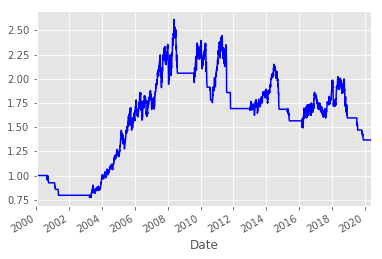

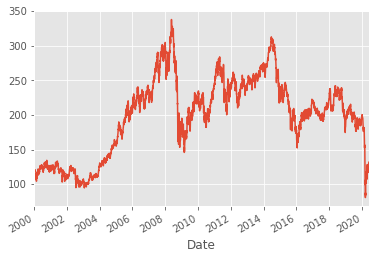

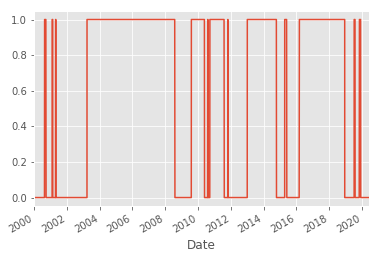

In [104]:
#個別產出

import matplotlib.pyplot as plt   
subject='能源'

p1=50
p2=12
p3=29

(price_train,price_test,price,indexes)=get_feature(subject)
(hold,eq,CUM_return,turnover,WIN_rate,MDD,gain_list,stop_gain,stop_loss,returns,CUM_return_b,MDD_b,df_tradingrecord,win_loss_ratio,WIN_rate_customer
,confidence)=backtest_antiMA(price,indexes,plot=False,p_rolling=p1,p_enter=p2,p_esc=p3)
print(subject)
print("累積報酬:{0:.2f}, MDD:{1:.2f}, 勝率:{2:.2f}, 進場次數:{3}, 賺賠比:{4:.2f},Total_return/MDD:{5:.2f},"
"客戶真實勝率:{6:.2f}".format(CUM_return,MDD,WIN_rate,turnover,win_loss_ratio,CUM_return/MDD,WIN_rate_customer))
print("benchmark累積報酬:{0:.2f}, benchmarkMDD:{1:.2f}, benchmark Total_return/MDD:{2:.2f}".format(CUM_return_b,MDD_b,CUM_return_b/MDD_b))
returns.cumprod().plot(color='B')
plt.show()
price.plot()
plt.show()
hold.plot()
plt.show()



In [ ]:
#參數優化~反均線策略 ~針對產業ETF
import pandas as pd
import numpy as np
import mymath

industry_dic={#'美國':'SPX Index',
              #'泛太平洋':'MXAP Index',
              '拉丁美洲':'MXLA Index',
              #'新興亞洲':'MXMS Index',
              #'新興歐洲':'MXMU Index',
              #'歐洲':'SX5P Index',
              #'非核心消費':'MXWO0CD Index',
              #'地產':'MXWO0RE Index',
              #'公用事業':'MXWO0UT Index',
              #'核心消費':'MXWO0CS Index',
              #'科技':'MXWO0IT Index',
              #'工業':'MXWO0IN Index',
              #'健護':'MXWO0HC Index',
              #'原物料':'MXWO0MT Index',
              #'能源':'MXWO0EN Index',
              #'金融':'MXWO0FN Index',
              #'電信':'MXWO0TC Index',

                 } 

return_list=[]    #要算portfolio R, MDD
import matplotlib.pyplot as plt 
from tqdm import tqdm

career_high=0



for p1 in tqdm(range(5,20,1)):

    for p2 in range(10,35,1):
        #獲取index 並創建dataframe 
        (price_train,price_test,price,indexes)=get_feature(subject='美國')
        (hold,eq,CUM_return,turnover,WIN_rate,MDD,gain_list,stop_gain,stop_loss,returns,CUM_return_b,
        MDD_b,df_tradingrecord,win_loss_ratio,WIN_rate_customer,confidence)=backtest_antiMA(price,indexes,plot=False,p_enter=p1,p_esc=p2)
        result = pd.DataFrame(np.nan, index=returns.index, columns=['test']).fillna(1)          
        result['portfolio']=0
        
        filter1=0  #個別產業基本條件
        for x in industry_dic.keys():    
            subject=x        
            (price_train,price_test,price,indexes)=get_feature(subject)
            (hold,eq,CUM_return,turnover,WIN_rate,MDD,gain_list,stop_gain,stop_loss,returns,CUM_return_b,
            MDD_b,df_tradingrecord,win_loss_ratio,WIN_rate_customer,confidence)=backtest_antiMA(price,indexes,plot=False,p_enter=p1,p_esc=p2)
            #print(x)
            #print("累積報酬:{0:.2f}, MDD:{1:.2f}, 勝率:{2:.2f}, 進場次數:{3}, 賺賠比:{4:.2f},Total_return/MDD:{5:.2f}".format(CUM_return,MDD,WIN_rate,turnover,win_loss_ratio,CUM_return/MDD))
            #print("benchmark累積報酬:{0:.2f}, benchmarkMDD:{1:.2f}, benchmark Total_return/MDD:{2:.2f}".format(CUM_return_b,MDD_b,CUM_return_b/MDD_b))
            #設定繪圖data
        
            result[x]=returns.fillna(1)
            if  (CUM_return/MDD)>(CUM_return_b/MDD_b) or ((CUM_return>CUM_return_b) & (MDD<MDD_b)):
                filter1=filter1+1
    
        for key,item in industry_dic.items():
            result['portfolio']=result['portfolio']+result[key]
        result['portfolio']=result['portfolio']/len(industry_dic) 
        portfolio_CUM_return=result['portfolio'].cumprod()[-1]-1
        portfolio_MDD=mymath.get_max_drawdown_fast(result['portfolio'].dropna().cumprod())
        if (portfolio_CUM_return>0)  &  (portfolio_MDD<0.76)  &  (filter1>=len(industry_dic)-2):
            print("portfolio累積報酬:{0:.2f}, portfolioMDD:{1:.2f},參數p1:{2:.2f},參數p2:{3:.2f}".format(portfolio_CUM_return,portfolio_MDD,p1,p2))
            career_high=portfolio_CUM_return

        

In [ ]:
#start='2012/9/1'
#end='2013/1/1'
#returns.cumprod()[start:end].plot(color='B')
#plt.show()
#eq[start:end].plot()
#plt.show()
#hold[start:end].plot()
import talib
atr = talib.NATR(eq,eq,eq,timeperiod=40)
atr.plot()

In [105]:

import talib
p_rolling=50
ADXR=talib.ADX(eq, eq, eq, p_rolling)

ADXR.max()

32.586862873480996

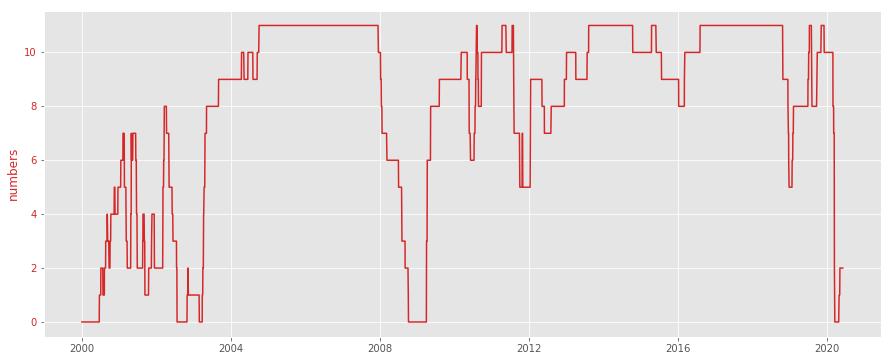

In [111]:
#df_hold['portfolio'].plot(title='出現訊號的產業個數')


#設定繪圖data


data1 = df_hold['portfolio']
fig, ax1= plt.subplots(figsize=(15,6)) 
#價格曲線
color = 'tab:red'
#ax1.set_xlabel('time')
ax1.set_ylabel('numbers', color=color)
ax1.plot(data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

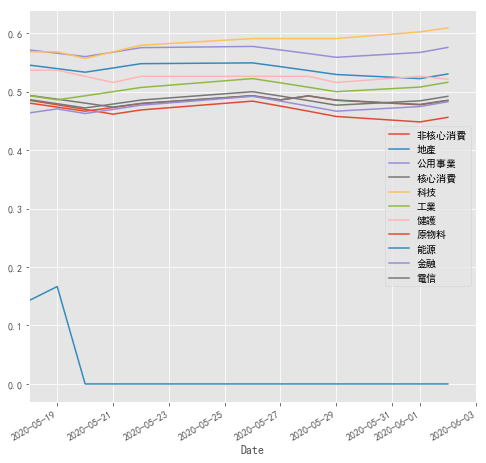

In [8]:
#信賴指數走勢圖 呈現
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.sans-serif']=['SimHei']
X=df_confidence.drop(['test'],axis=1)['2020/5/17':]
X.plot(figsize=(8,8))